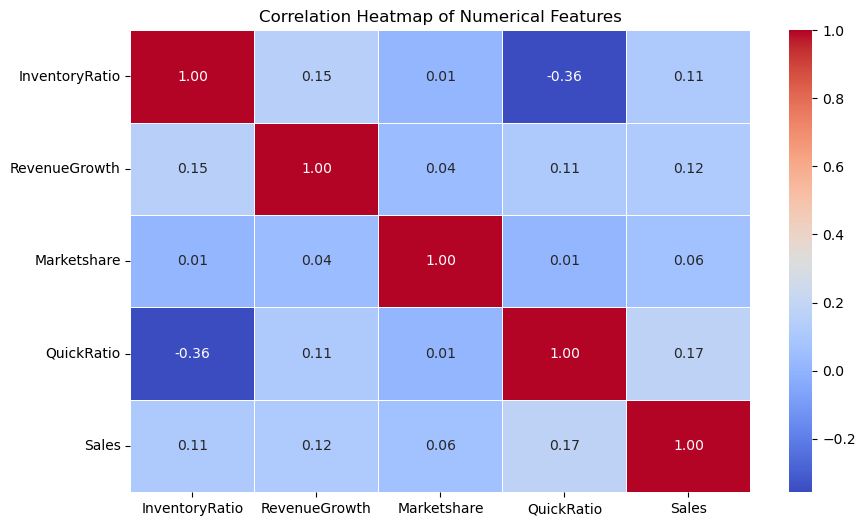

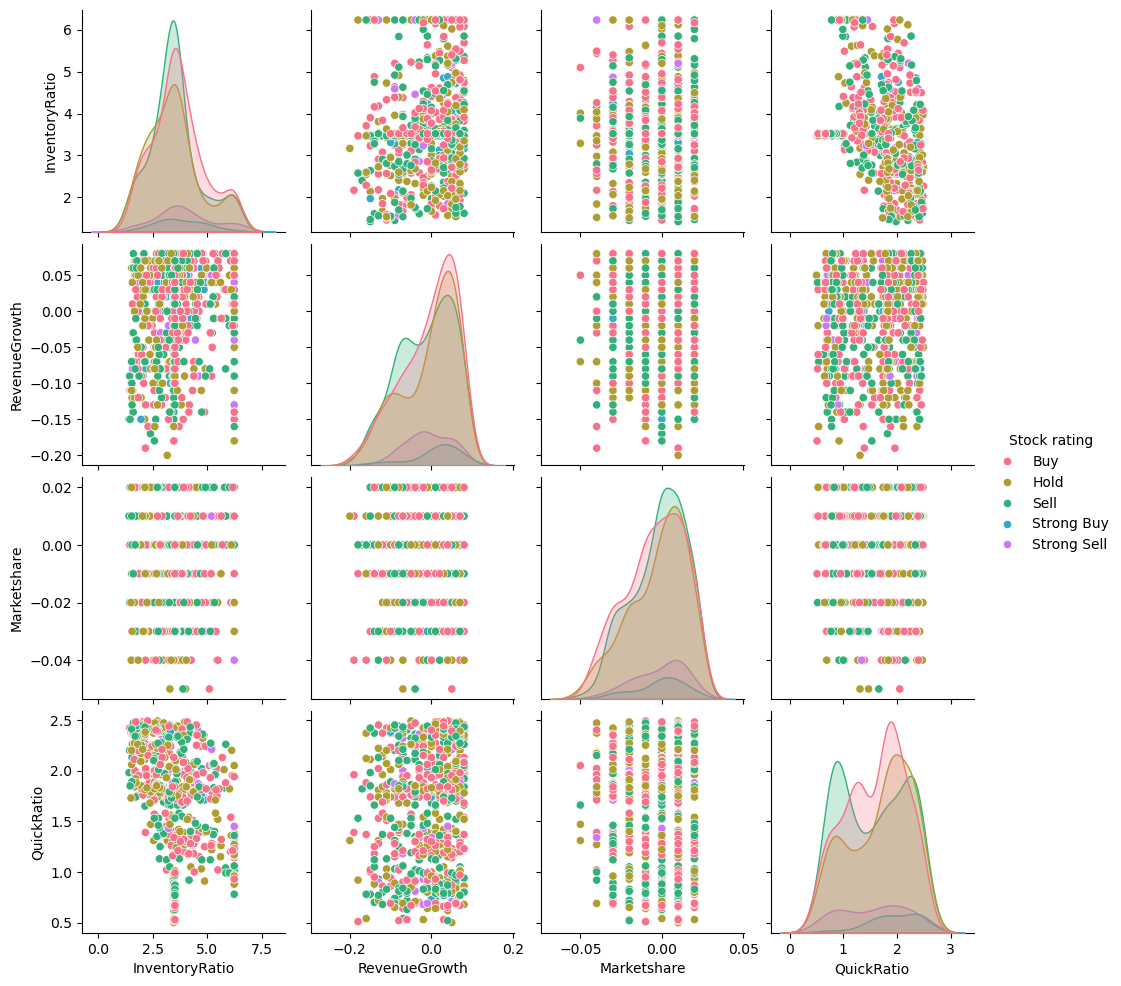

Correlation Matrix:
                InventoryRatio  RevenueGrowth  Marketshare  QuickRatio  \
InventoryRatio        1.000000       0.151329     0.010201   -0.357501   
RevenueGrowth         0.151329       1.000000     0.039906    0.111782   
Marketshare           0.010201       0.039906     1.000000    0.012461   
QuickRatio           -0.357501       0.111782     0.012461    1.000000   
Sales                 0.112127       0.115264     0.061794    0.173583   

                   Sales  
InventoryRatio  0.112127  
RevenueGrowth   0.115264  
Marketshare     0.061794  
QuickRatio      0.173583  
Sales           1.000000  


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned datasets
test_cleaned_path = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/test_cleaned_final.csv"
train_cleaned_path = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/train_cleaned_final.csv"

test_df = pd.read_csv(test_cleaned_path)
train_df = pd.read_csv(train_cleaned_path)

# Combine train and test datasets for better analysis
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Convert categorical columns to category type for analysis
categorical_columns = ["Bond rating", "Stock rating", "Region", "Industry", "Company", "Quarter"]
for col in categorical_columns:
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].astype("category")

# Define numerical columns
numeric_columns = ["InventoryRatio", "RevenueGrowth", "Marketshare", "QuickRatio", "Sales"]

# Convert non-numeric values to NaN for cleaning
for col in numeric_columns:
    combined_df[col] = pd.to_numeric(combined_df[col], errors="coerce")

# Drop rows with NaN values in numerical columns to ensure smooth visualization
cleaned_combined_df = combined_df.dropna(subset=["InventoryRatio", "RevenueGrowth", "Marketshare", "QuickRatio"])

# Compute correlation matrix for numerical columns
corr_matrix = combined_df.select_dtypes(include=["float64"]).corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Generate pairplot for numerical features (excluding 'Sales' due to missing values in test set)
sns.pairplot(cleaned_combined_df, vars=["InventoryRatio", "RevenueGrowth", "Marketshare", "QuickRatio"], hue="Stock rating", palette="husl")
plt.show()

# # Save cleaned data
# test_cleaned_path = "test_cleaned_final_processed.csv"
# train_cleaned_path = "train_cleaned_final_processed.csv"
# test_df.to_csv(test_cleaned_path, index=False)
# train_df.to_csv(train_cleaned_path, index=False)

# Display correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

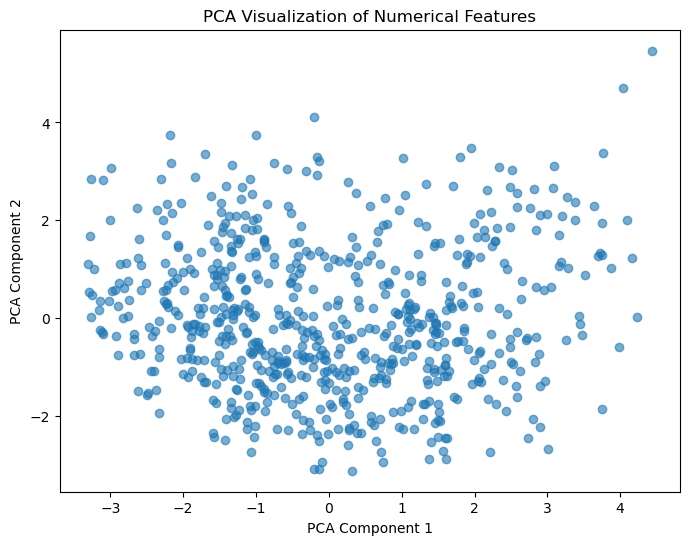

Explained Variance Ratio: [0.32388322 0.24349978]


In [12]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the cleaned dataset
combined_cleaned_path = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/combined_cleaned_final.csv"
combined_df = pd.read_csv(combined_cleaned_path)

# Define numerical columns
numeric_columns = ["InventoryRatio", "RevenueGrowth", "Marketshare", "QuickRatio", "Sales",
                   "Inventory_to_QuickRatio", "Sales_to_InventoryRatio", "RevenueGrowth_to_QuickRatio", "InventoryRatio_x_QuickRatio"]

# Step 3: Normalize Skewed Data using Log Transformation (for positive values)
for col in numeric_columns:
    if (combined_df[col] > 0).all():  # Apply log transformation only to positive values
        combined_df[col] = np.log1p(combined_df[col])

# Step 4: PCA - Dimensionality Reduction
scaler = StandardScaler()
pca = PCA(n_components=2)

# Standardize before PCA
scaled_data = scaler.fit_transform(combined_df[numeric_columns])
pca_results = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_results, columns=["PCA1", "PCA2"])
pca_df["Explained Variance PCA1"] = pca.explained_variance_ratio_[0]
pca_df["Explained Variance PCA2"] = pca.explained_variance_ratio_[1]

# Save updated dataset
pca_output_path = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/combined_cleaned_final_pca.csv"
pca_df.to_csv(pca_output_path, index=False)

# Plot PCA Components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df["PCA1"], pca_df["PCA2"], alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Numerical Features")
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mean Absolute Error (Train): 1024.5010770459992
Mean Absolute Error (Test/Validation): 1311.2181976124507
Best Hyperparameters: {'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}


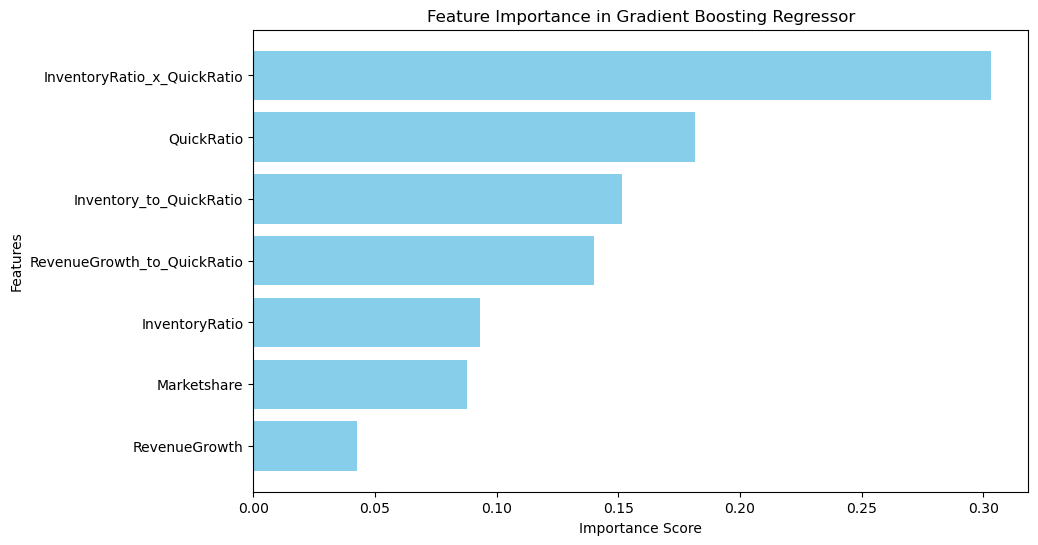

                       Feature  Importance
6  InventoryRatio_x_QuickRatio    0.303283
3                   QuickRatio    0.181592
4      Inventory_to_QuickRatio    0.151365
5  RevenueGrowth_to_QuickRatio    0.139868
0               InventoryRatio    0.093328
2                  Marketshare    0.087937
1                RevenueGrowth    0.042627


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# Load the cleaned dataset
combined_cleaned_path = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/combined_cleaned_final.csv"
combined_df = pd.read_csv(combined_cleaned_path)

# Define features and target (excluding 'Sales' and 'Sales_to_InventoryRatio' to prevent data leakage)
numeric_columns = ["InventoryRatio", "RevenueGrowth", "Marketshare", "QuickRatio",
                   "Inventory_to_QuickRatio", "RevenueGrowth_to_QuickRatio", "InventoryRatio_x_QuickRatio"]
features = combined_df[numeric_columns]
target = combined_df["Sales"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define GBR model with lower learning rate and more trees
gbr = GradientBoostingRegressor(random_state=42)

gbr_params = {
    'n_estimators': [200, 300, 400],  # Increase number of trees
    'learning_rate': [0.005, 0.01, 0.02],  # Lower learning rate
    'max_depth': [4, 5],
    'subsample': [0.8],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [2, 5]
}
gbr_grid = GridSearchCV(gbr, gbr_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
gbr_grid.fit(X_train_scaled, y_train)
best_gbr = gbr_grid.best_estimator_

# Evaluate model on train and test sets
y_train_pred = best_gbr.predict(X_train_scaled)
y_test_pred = best_gbr.predict(X_test_scaled)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print train and test errors
print("Mean Absolute Error (Train):", mae_train)
print("Mean Absolute Error (Test/Validation):", mae_test)
print("Best Hyperparameters:", gbr_grid.best_params_)

# Feature Importance Analysis
feature_importances = best_gbr.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": numeric_columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Gradient Boosting Regressor")
plt.gca().invert_yaxis()
plt.show()

# Print Feature Importance DataFrame
print(feature_importance_df) 

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Gradient Boosting Regressor (Log-Transformed Sales):
Mean Absolute Error (Train): 0.2774953842932588
Mean Absolute Error (Test/Validation): 0.3665115841800023
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}

Linear Regression (Log-Transformed Sales):
Mean Absolute Error (Train): 0.35705503360386703
Mean Absolute Error (Test/Validation): 0.3772804093846766


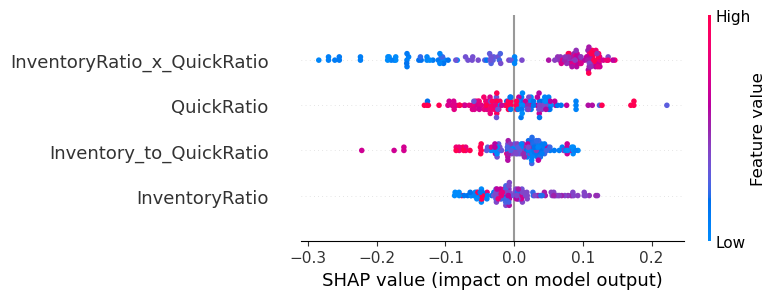

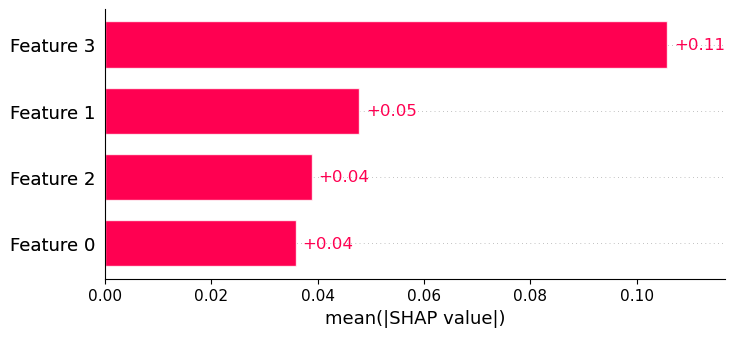

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Load the cleaned dataset
combined_cleaned_path = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/combined_cleaned_final.csv"
combined_df = pd.read_csv(combined_cleaned_path)

# Define features and apply log transformation to target
selected_features = ["InventoryRatio", "QuickRatio", "Inventory_to_QuickRatio", "InventoryRatio_x_QuickRatio"]
features = combined_df[selected_features]
target = np.log1p(combined_df["Sales"])  # Apply log transformation to Sales

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fine-tune GBR with a broader range of hyperparameters
gbr = GradientBoostingRegressor(random_state=42)

gbr_params = {
    'n_estimators': [200, 300, 500],  # Increase number of trees
    'learning_rate': [0.005, 0.01, 0.02, 0.05],  # Experiment with lower rates
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10]
}
gbr_grid = GridSearchCV(gbr, gbr_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
gbr_grid.fit(X_train_scaled, y_train)
best_gbr = gbr_grid.best_estimator_

# Train Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Evaluate GBR Model
y_train_pred_gbr = best_gbr.predict(X_train_scaled)
y_test_pred_gbr = best_gbr.predict(X_test_scaled)
mae_train_gbr = mean_absolute_error(y_train, y_train_pred_gbr)
mae_test_gbr = mean_absolute_error(y_test, y_test_pred_gbr)

# Evaluate Linear Regression Model
y_train_pred_lr = lr.predict(X_train_scaled)
y_test_pred_lr = lr.predict(X_test_scaled)
mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)
mae_test_lr = mean_absolute_error(y_test, y_test_pred_lr)

# Print Model Comparisons
print("Gradient Boosting Regressor (Log-Transformed Sales):")
print("Mean Absolute Error (Train):", mae_train_gbr)
print("Mean Absolute Error (Test/Validation):", mae_test_gbr)
print("Best Hyperparameters:", gbr_grid.best_params_)

print("\nLinear Regression (Log-Transformed Sales):")
print("Mean Absolute Error (Train):", mae_train_lr)
print("Mean Absolute Error (Test/Validation):", mae_test_lr)

# Feature Impact Analysis using SHAP
explainer = shap.Explainer(best_gbr, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=selected_features)
plt.show()

# Feature Importance Plot
shap.plots.bar(shap_values)


Feature Importance:
                        Feature  Importance
18           QuickRatio_x_Sales    0.732721
9                    QuickRatio    0.094567
17           Inventory_to_Sales    0.048844
16                    Sales_MA3    0.039386
11      Sales_to_InventoryRatio    0.035411
10      Inventory_to_QuickRatio    0.024698
6                InventoryRatio    0.017143
14                   Sales_Lag1    0.004728
0                       Quarter    0.002340
15                   Sales_Lag2    0.000140
1                       Company    0.000022
3                  Stock rating    0.000000
8                   Marketshare    0.000000
12  RevenueGrowth_to_QuickRatio    0.000000
13  InventoryRatio_x_QuickRatio    0.000000
7                 RevenueGrowth    0.000000
5                      Industry    0.000000
4                        Region    0.000000
2                   Bond rating    0.000000


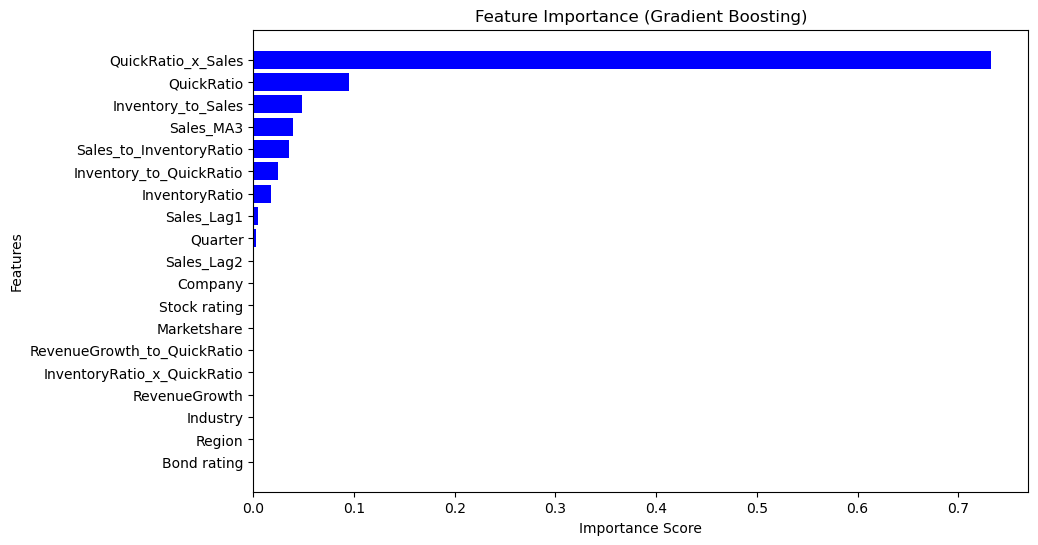

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute feature importances
feature_importances = gbr.feature_importances_
feature_names = selected_features

# Create a DataFrame for visualization
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display the importance table
print("\nFeature Importance:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (Gradient Boosting)")
plt.gca().invert_yaxis()
plt.show()


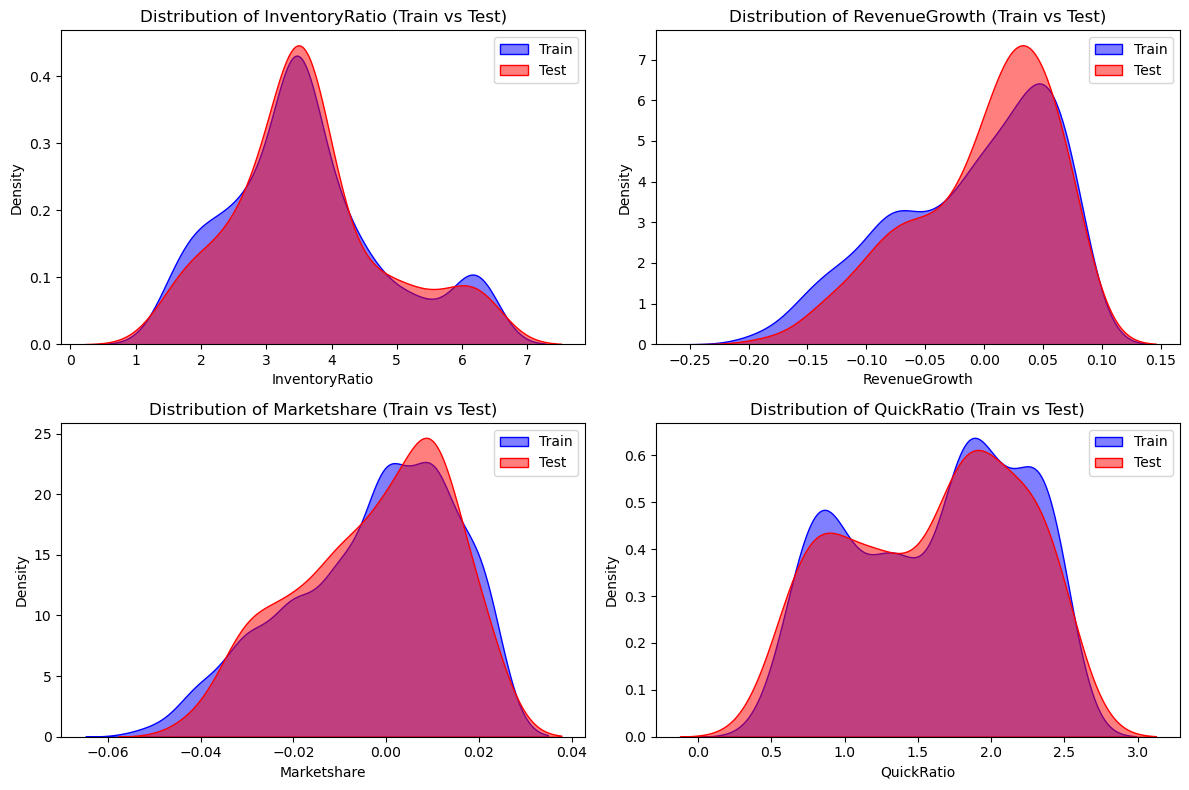


📊 Train Feature Statistics:
        InventoryRatio  RevenueGrowth  Marketshare  QuickRatio
count      525.000000     525.000000   525.000000  525.000000
mean         3.587333      -0.010400    -0.002914    1.622019
std          1.217118       0.068026     0.017389    0.581223
min          1.420000      -0.200000    -0.050000    0.500000
25%          2.760000      -0.070000    -0.010000    1.050000
50%          3.470000       0.000000     0.000000    1.750000
75%          4.150000       0.050000     0.010000    2.120000
max          6.235000       0.080000     0.020000    2.490000

📊 Test Feature Statistics:
        InventoryRatio  RevenueGrowth  Marketshare  QuickRatio
count      150.000000     150.000000   150.000000  150.000000
mean         3.629900      -0.001267    -0.002600    1.602867
std          1.165824       0.059712     0.016155    0.585409
min          1.510000      -0.180000    -0.040000    0.520000
25%          2.850000      -0.040000    -0.010000    1.075000
50%        

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned datasets
train_cleaned_fixed = pd.read_csv("/Users/jiayiluo/Desktop/sp-25-sales-forecasting/train_cleaned_fixed.csv")
test_cleaned_fixed = pd.read_csv("/Users/jiayiluo/Desktop/sp-25-sales-forecasting/test_cleaned_fixed.csv")

# Select numerical features for distribution comparison
numeric_features = ["InventoryRatio", "RevenueGrowth", "Marketshare", "QuickRatio"]

# 🔍 Plot feature distributions (Train vs Test)
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(train_cleaned_fixed[feature], label="Train", fill=True, color="blue", alpha=0.5)
    sns.kdeplot(test_cleaned_fixed[feature], label="Test", fill=True, color="red", alpha=0.5)
    plt.title(f"Distribution of {feature} (Train vs Test)")
    plt.legend()

plt.tight_layout()
plt.show()

# 🔍 Compute basic distribution statistics for comparison
train_stats = train_cleaned_fixed[numeric_features].describe()
test_stats = test_cleaned_fixed[numeric_features].describe()

# ✅ Display statistics for comparison
print("\n📊 Train Feature Statistics:\n", train_stats)
print("\n📊 Test Feature Statistics:\n", test_stats)


<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/var/folders/nr/g7k41wd90wj7m_w0dgnqy_vm0000gn/T/ipykernel_38436/1433102820.py:14: SyntaxWarning: invalid escape sequence '\d'
  train_df["Quarter_Num"] = train_df["Quarter"].str.extract("(\d+)").astype(int)  # Extract numeric part of quarter


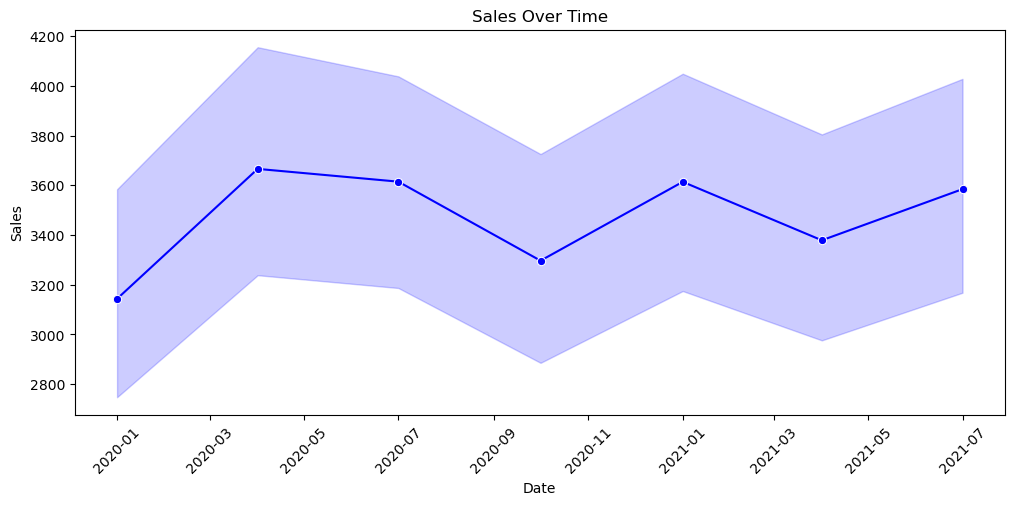

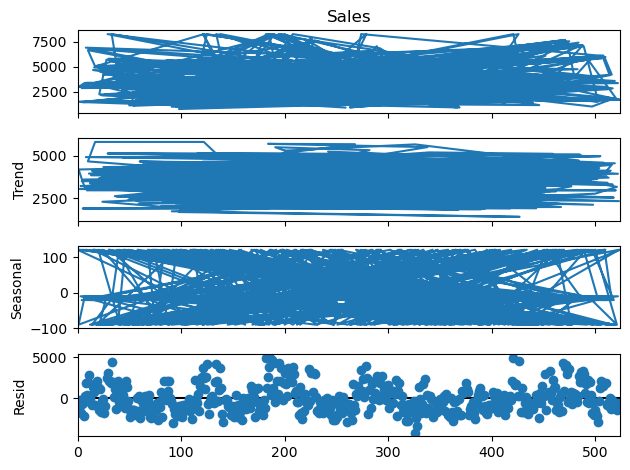

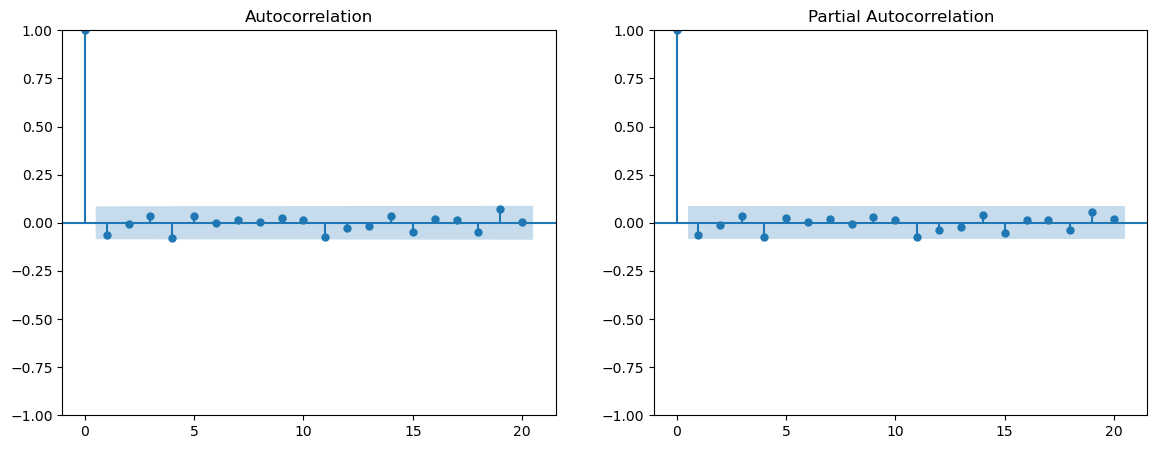

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the cleaned train dataset
train_cleaned_fixed_path = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/train_cleaned_fixed.csv"
train_df = pd.read_csv(train_cleaned_fixed_path)

# ✅ Convert "Quarter" column into a proper date format
if "Quarter" in train_df.columns:
    train_df["Quarter_Num"] = train_df["Quarter"].str.extract("(\d+)").astype(int)  # Extract numeric part of quarter

    # ✅ Assign Year Based on Quarter Progression
    start_year = 2020  # Adjust this if needed
    train_df["Year"] = start_year + (train_df["Quarter_Num"] - 1) // 4  # Ensures correct year mapping

    # ✅ Convert Quarter Number to Month
    train_df["Month"] = ((train_df["Quarter_Num"] - 1) % 4) * 3 + 1  # Converts Q1=Jan, Q2=Apr, etc.
    train_df["Day"] = 1  # Assign day for proper datetime conversion

    # ✅ Convert to datetime
    train_df["Date"] = pd.to_datetime(train_df[["Year", "Month", "Day"]])
    
    # Sort by date
    train_df = train_df.sort_values("Date")

# 📊 1. Plot Sales Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x=train_df["Date"], y=train_df["Sales"], marker="o", color="blue")
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()

# 📊 2. Seasonal Decomposition (Check for Trend & Seasonality)
decomposition = seasonal_decompose(train_df["Sales"], period=4, model="additive")  # Adjust period if needed
decomposition.plot()
plt.show()

# 📊 3. Autocorrelation & Partial Autocorrelation (Detect Seasonality)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(train_df["Sales"], ax=ax[0], lags=20)
plot_pacf(train_df["Sales"], ax=ax[1], lags=20)
plt.show()


<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:80: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:80: SyntaxWarning: invalid escape sequence '\d'
/var/folders/nr/g7k41wd90wj7m_w0dgnqy_vm0000gn/T/ipykernel_38436/3303428730.py:16: SyntaxWarning: invalid escape sequence '\d'
  train_df["Quarter_Num"] = train_df["Quarter"].str.extract("(\d+)").astype(int)
/var/folders/nr/g7k41wd90wj7m_w0dgnqy_vm0000gn/T/ipykernel_38436/3303428730.py:80: SyntaxWarning: invalid escape sequence '\d'
  test_df["Quarter_Num"] = test_df["Quarter"].str.extract("(\d+)").astype(int)
/var/folders/nr/g7k41wd90wj7m_w0dgnqy_vm0000gn/T/ipykernel_38436/3303428730.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method="bfill", inplace=True)



📊 XGBoost Model Evaluation (With Fixed Lag Features):
Train MAE: 87.54
Validation MAE: 764.54


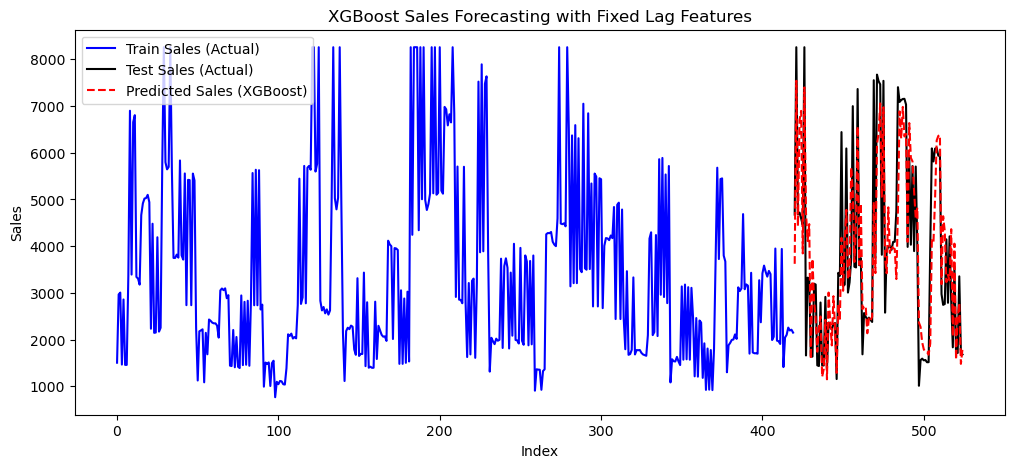


🚀 Final submission saved: /Users/jiayiluo/Desktop/sp-25-sales-forecasting/final_submission_xgboost_yeah.csv
   RowID        Sales
0      1  2688.620117
1      2  2644.729980
2      3  2412.330078
3      4  2407.070068
4      5  2140.090088


In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# 🚀 Load the cleaned train dataset
train_cleaned_fixed_path = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/train_cleaned_fixed.csv"
train_df = pd.read_csv(train_cleaned_fixed_path)

# ✅ Convert "Quarter" to numeric features
if "Quarter" in train_df.columns:
    train_df["Quarter_Num"] = train_df["Quarter"].str.extract("(\d+)").astype(int)

# 🚀 Feature Engineering: Add Lag Features
train_df["Sales_Lag1"] = train_df["Sales"].shift(1)  # Sales from last quarter
train_df["Sales_Lag2"] = train_df["Sales"].shift(2)  # Sales from 2 quarters ago
train_df["Sales_MA4"] = train_df["Sales"].rolling(window=4).mean()  # 4-quarter moving average

# Fill NaN values (from shifting)
train_df.fillna(method="bfill", inplace=True)

# ✅ Select Features & Target
selected_features = ["InventoryRatio", "RevenueGrowth", "Marketshare", "QuickRatio", 
                     "Quarter_Num", "Sales_Lag1", "Sales_Lag2", "Sales_MA4"]
X = train_df[selected_features]
y = train_df["Sales"]

# ✅ Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🚀 Train-Test Split (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# 🚀 Train XGBoost Model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,  # Number of trees
    learning_rate=0.05,  # Controls weight updates
    max_depth=4,  # Tree depth (controls complexity)
    subsample=0.8,  # Randomly select 80% of data for each tree
    colsample_bytree=0.8,  # Randomly select 80% of features
    objective="reg:squarederror",
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 🚀 Predict on Train & Test Sets
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# 📊 Evaluate Model Performance
train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)

print("\n📊 XGBoost Model Evaluation (With Fixed Lag Features):")
print(f"Train MAE: {train_mae:.2f}")
print(f"Validation MAE: {test_mae:.2f}")

# 📊 Plot Actual vs. Predicted Sales
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label="Train Sales (Actual)", color="blue")
plt.plot(y_test.index, y_test, label="Test Sales (Actual)", color="black")
plt.plot(y_test.index, test_pred, label="Predicted Sales (XGBoost)", color="red", linestyle="dashed")
plt.title("XGBoost Sales Forecasting with Fixed Lag Features")
plt.xlabel("Index")
plt.ylabel("Sales")
plt.legend()
plt.show()

# 🚀 5. Predict on the Full Test Dataset (for Kaggle Submission)
test_cleaned_fixed_path = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/test_cleaned_fixed.csv"
test_df = pd.read_csv(test_cleaned_fixed_path)

# ✅ Convert "Quarter" to numeric
test_df["Quarter_Num"] = test_df["Quarter"].str.extract("(\d+)").astype(int)

# 🚀 **Fix `Sales_Lag1` for Test Data**
# ✅ Assign the last known sales values from the training set
test_df["Sales_Lag1"] = train_df["Sales"].iloc[-1]  # Last known sales value
test_df["Sales_Lag2"] = train_df["Sales"].iloc[-2]  # Two periods back
test_df["Sales_MA4"] = train_df["Sales"].rolling(window=4).mean().iloc[-1]  # Last known moving average

# ✅ Extract Features & Scale
X_test_final = test_df[selected_features]
X_test_final_scaled = scaler.transform(X_test_final)

# ✅ Predict Sales
final_sales_pred = xgb_model.predict(X_test_final_scaled)
final_sales_pred = np.round(final_sales_pred, 2)

# ✅ Ensure "RowID" exists (if missing, create it)
if "RowID" not in test_df.columns:
    test_df["RowID"] = range(1, len(test_df) + 1)

# ✅ Create Submission DataFrame
submission_df = test_df[["RowID"]].copy()
submission_df["Sales"] = final_sales_pred

# ✅ Save Kaggle Submission
submission_file = "/Users/jiayiluo/Desktop/sp-25-sales-forecasting/final_submission_xgboost_yeah.csv"
submission_df.to_csv(submission_file, index=False)

print(f"\n🚀 Final submission saved: {submission_file}")
print(submission_df.head())  # Show first few predictions


/var/folders/nr/g7k41wd90wj7m_w0dgnqy_vm0000gn/T/ipykernel_38436/938000260.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(test_df[feature], label="Test", color="red")


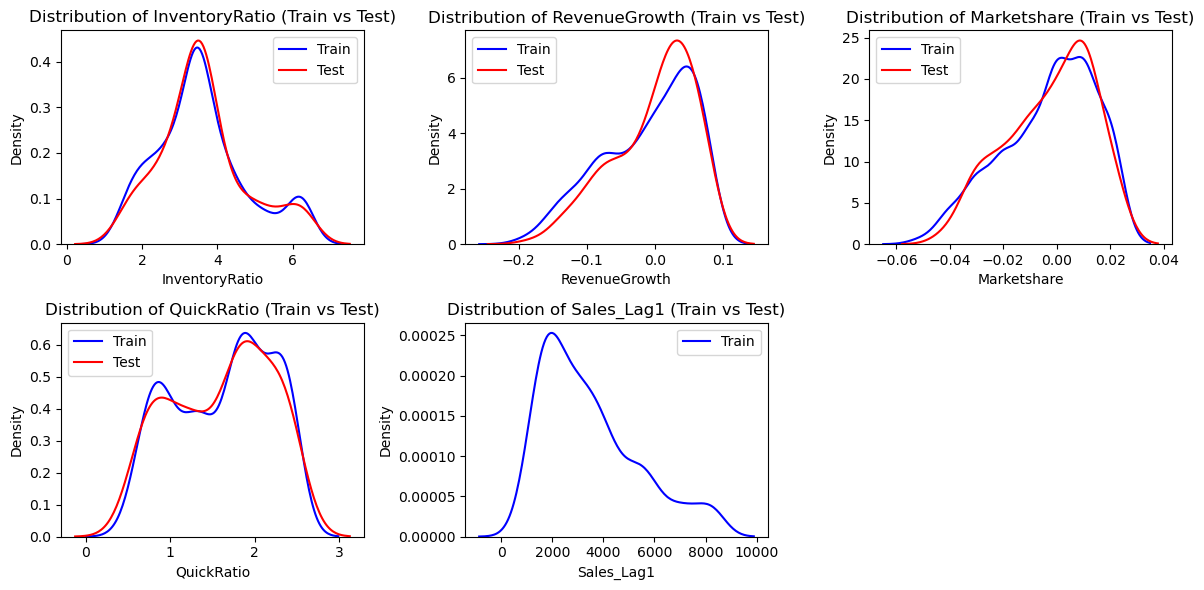

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🚀 Compare Train vs Test Distributions
features_to_check = ["InventoryRatio", "RevenueGrowth", "Marketshare", "QuickRatio", "Sales_Lag1"]

plt.figure(figsize=(12, 6))
for i, feature in enumerate(features_to_check):
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(train_df[feature], label="Train", color="blue")
    sns.kdeplot(test_df[feature], label="Test", color="red")
    plt.title(f"Distribution of {feature} (Train vs Test)")
    plt.legend()

plt.tight_layout()
plt.show()
